In [3]:
import IPython
import os
import json
import random
import json
import cv2
import matplotlib.pyplot as plt
import numpy as np
import requests
from io import BytesIO
import base64
from math import trunc
from PIL import Image as PILImage
from PIL import ImageDraw as PILImageDraw
from quickdraw import QuickDrawDataGroup
from quickdraw import QuickDrawData
from pycocotools.coco import COCO
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
import pylab

In [4]:
# Load the dataset json
class CocoDataset():
    def __init__(self, annotation_path, image_dir):
        self.annotation_path = annotation_path
        self.image_dir = image_dir
        self.colors = colors = ['blue', 'purple', 'red', 'green', 'orange', 'salmon', 'pink', 'gold',
                                'orchid', 'slateblue', 'limegreen', 'seagreen', 'darkgreen', 'olive',
                               'teal', 'aquamarine', 'steelblue', 'powderblue', 'dodgerblue', 'navy',
                               'magenta', 'sienna', 'maroon']
        
        json_file = open(self.annotation_path)
        self.coco = json.load(json_file)
        json_file.close()
        
        self.process_info()
        self.process_licenses()
        self.process_categories()
        self.process_images()
        self.process_segmentations()
            
        
    def display_info(self):
        print('Dataset Info:')
        print('=============')
        for key, item in self.info.items():
            print('  {}: {}'.format(key, item))
        
        requirements = [['description', str],
                        ['url', str],
                        ['version', str],
                        ['year', int],
                        ['contributor', str],
                        ['date_created', str]]
        for req, req_type in requirements:
            if req not in self.info:
                print('ERROR: {} is missing'.format(req))
            elif type(self.info[req]) != req_type:
                print('ERROR: {} should be type {}'.format(req, str(req_type)))
        print('')

        
    def display_licenses(self):
        print('Licenses:')
        print('=========')
        
        requirements = [['id', int],
                        ['url', str],
                        ['name', str]]
        for license in self.licenses:
            for key, item in license.items():
                print('  {}: {}'.format(key, item))
            for req, req_type in requirements:
                if req not in license:
                    print('ERROR: {} is missing'.format(req))
                elif type(license[req]) != req_type:
                    print('ERROR: {} should be type {}'.format(req, str(req_type)))
            print('')
        print('')
        
    def display_categories(self):
        print('Categories:')
        print('=========')
        for sc_key, sc_val in self.super_categories.items():
            print('  super_category: {}'.format(sc_key))
            for cat_id in sc_val:
                print('    id {}: {}'.format(cat_id, self.categories[cat_id]['name']))
            print('')
    
    def return_bbox(self, image_id, show_polys=True, use_url=False):
        bbox = []
        if image_id == 'random':
            image_id = random.choice(list(self.images.keys()))
        
        # Print the image info
        image = self.images[image_id]
        for key, val in image.items():
            print('  {}: {}'.format(key, val))
            
        # Open the image
        if use_url:
            image_path = image['coco_url']
            response = requests.get(image_path)
            image = PILImage.open(BytesIO(response.content))
            
        else:
            image_path = os.path.join(self.image_dir, image['file_name'])
            image = PILImage.open(image_path)
            
            buffer = BytesIO()
            image.save(buffer, format='PNG')
            buffer.seek(0)
            
            data_uri = base64.b64encode(buffer.read()).decode('ascii')
            image_path = "data:image/png;base64,{0}".format(data_uri)
            
        # Calculate the size and adjusted display size
        max_width = 600
        image_width, image_height = image.size
        adjusted_width = min(image_width, max_width)
        adjusted_ratio = adjusted_width / image_width
        adjusted_height = adjusted_ratio * image_height
        
        # Create list of polygons to be drawn
        polygons = {}
        bbox_polygons = {}
        
        for i, segm in enumerate(self.segmentations[image_id]):
            bbox = segm['bbox']
            bbox_points = [bbox[0], bbox[1], bbox[0] + bbox[2], bbox[1],
                           bbox[0] + bbox[2], bbox[1] + bbox[3], bbox[0], bbox[1] + bbox[3],
                           bbox[0], bbox[1]]
            bbox_points = np.multiply(bbox_points, adjusted_ratio).astype(int)
            bbox_polygons[segm['id']] = str(bbox_points).lstrip('[').rstrip(']')
        return bbox_polygons
    
    def display_image(self, image_id, show_polys=True, show_bbox=True, show_crowds=True, use_url=False):
        print('Image:')
        print('======')
        if image_id == 'random':
            image_id = random.choice(list(self.images.keys()))
        
        # Print the image info
        image = self.images[image_id]
        for key, val in image.items():
            print('  {}: {}'.format(key, val))
            
        # Open the image
        if use_url:
            image_path = image['coco_url']
            response = requests.get(image_path)
            image = PILImage.open(BytesIO(response.content))
            
        else:
            image_path = os.path.join(self.image_dir, image['file_name'])
            image = PILImage.open(image_path)
            
            buffer = BytesIO()
            image.save(buffer, format='PNG')
            buffer.seek(0)
            
            data_uri = base64.b64encode(buffer.read()).decode('ascii')
            image_path = "data:image/png;base64,{0}".format(data_uri)
            
        # Calculate the size and adjusted display size
        max_width = 600
        image_width, image_height = image.size
        adjusted_width = min(image_width, max_width)
        adjusted_ratio = adjusted_width / image_width
        adjusted_height = adjusted_ratio * image_height
        
        # Create list of polygons to be drawn
        polygons = {}
        bbox_polygons = {}
        rle_regions = {}
        poly_colors = {}
        print('  segmentations ({}):'.format(len(self.segmentations[image_id])))
        for i, segm in enumerate(self.segmentations[image_id]):
            polygons_list = []
            if segm['iscrowd'] != 0:
                # Gotta decode the RLE
                px = 0
                x, y = 0, 0
                rle_list = []
                for j, counts in enumerate(segm['segmentation']['counts']):
                    if j % 2 == 0:
                        # Empty pixels
                        px += counts
                    else:
                        # Need to draw on these pixels, since we are drawing in vector form,
                        # we need to draw horizontal lines on the image
                        x_start = trunc(trunc(px / image_height) * adjusted_ratio)
                        y_start = trunc(px % image_height * adjusted_ratio)
                        px += counts
                        x_end = trunc(trunc(px / image_height) * adjusted_ratio)
                        y_end = trunc(px % image_height * adjusted_ratio)
                        if x_end == x_start:
                            # This is only on one line
                            rle_list.append({'x': x_start, 'y': y_start, 'width': 1 , 'height': (y_end - y_start)})
                        if x_end > x_start:
                            # This spans more than one line
                            # Insert top line first
                            rle_list.append({'x': x_start, 'y': y_start, 'width': 1, 'height': (image_height - y_start)})
                            
                            # Insert middle lines if needed
                            lines_spanned = x_end - x_start + 1 # total number of lines spanned
                            full_lines_to_insert = lines_spanned - 2
                            if full_lines_to_insert > 0:
                                full_lines_to_insert = trunc(full_lines_to_insert * adjusted_ratio)
                                rle_list.append({'x': (x_start + 1), 'y': 0, 'width': full_lines_to_insert, 'height': image_height})
                                
                            # Insert bottom line
                            rle_list.append({'x': x_end, 'y': 0, 'width': 1, 'height': y_end})
                if len(rle_list) > 0:
                    rle_regions[segm['id']] = rle_list  
            else:
                # Add the polygon segmentation
                for segmentation_points in segm['segmentation']:
                    segmentation_points = np.multiply(segmentation_points, adjusted_ratio).astype(int)
                    polygons_list.append(str(segmentation_points).lstrip('[').rstrip(']'))
            polygons[segm['id']] = polygons_list
            if i < len(self.colors):
                poly_colors[segm['id']] = self.colors[i]
            else:
                poly_colors[segm['id']] = 'white'
            
            bbox = segm['bbox']
            bbox_points = [bbox[0], bbox[1], bbox[0] + bbox[2], bbox[1],
                           bbox[0] + bbox[2], bbox[1] + bbox[3], bbox[0], bbox[1] + bbox[3],
                           bbox[0], bbox[1]]
            bbox_points = np.multiply(bbox_points, adjusted_ratio).astype(int)
            bbox_polygons[segm['id']] = str(bbox_points).lstrip('[').rstrip(']')
            
            # Print details
            print('    {}:{}:{}'.format(segm['id'], poly_colors[segm['id']], self.categories[segm['category_id']]))
        
        
        
        # Draw segmentation polygons on image
        html  = '<div class="container" style="position:relative;">'
        html += '<img src="{}" style="position:relative;top:0px;left:0px;width:{}px;">'.format(image_path, adjusted_width)
        html += '<div class="svgclass"><svg width="{}" height="{}">'.format(adjusted_width, adjusted_height)
        
        if show_polys:
            for seg_id, points_list in polygons.items():
                fill_color = poly_colors[seg_id]
                stroke_color = poly_colors[seg_id]
                for points in points_list:
                    html += '<polygon points="{}" style="fill:{}; stroke:{}; stroke-width:1; fill-opacity:0.5" />'.format(points, fill_color, stroke_color)
        
        if show_crowds:
            for seg_id, rect_list in rle_regions.items():
                fill_color = poly_colors[seg_id]
                stroke_color = poly_colors[seg_id]
                for rect_def in rect_list:
                    x, y = rect_def['x'], rect_def['y']
                    w, h = rect_def['width'], rect_def['height']
                    html += '<rect x="{}" y="{}" width="{}" height="{}" style="fill:{}; stroke:{}; stroke-width:1; fill-opacity:0.5; stroke-opacity:0.5" />'.format(x, y, w, h, fill_color, stroke_color)
            
        if show_bbox:
            for seg_id, points in bbox_polygons.items():
                fill_color = poly_colors[seg_id]
                stroke_color = poly_colors[seg_id]
                html += '<polygon points="{}" style="fill:{}; stroke:{}; stroke-width:1; fill-opacity:0" />'.format(points, fill_color, stroke_color)
                
        html += '</svg></div>'
        html += '</div>'
        html += '<style>'
        html += '.svgclass { position:absolute; top:0px; left:0px;}'
        html += '</style>'
        return html
       
    def process_info(self):
        self.info = self.coco['info']
    
    def process_licenses(self):
        self.licenses = self.coco['licenses']
    
    def process_categories(self):
        self.categories = {}
        self.super_categories = {}
        for category in self.coco['categories']:
            cat_id = category['id']
            super_category = category['supercategory']
            
            # Add category to the categories dict
            if cat_id not in self.categories:
                self.categories[cat_id] = category
            else:
                print("ERROR: Skipping duplicate category id: {}".format(category))

            # Add category to super_categories dict
            if super_category not in self.super_categories:
                self.super_categories[super_category] = {cat_id} # Create a new set with the category id
            else:
                self.super_categories[super_category] |= {cat_id} # Add category id to the set
                
    def process_images(self):
        self.images = {}
        for image in self.coco['images']:
            image_id = image['id']
            if image_id in self.images:
                print("ERROR: Skipping duplicate image id: {}".format(image))
            else:
                self.images[image_id] = image
                
    def process_segmentations(self):
        self.segmentations = {}
        for segmentation in self.coco['annotations']:
            image_id = segmentation['image_id']
            if image_id not in self.segmentations:
                self.segmentations[image_id] = []
            self.segmentations[image_id].append(segmentation)

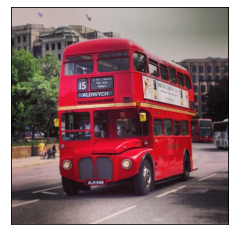

In [6]:
img = cv2.imread('coco/val2017/000000001584.jpg',1)
Cimg = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.imshow(Cimg, cmap = 'gray')
plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
plt.show()





loading bus drawings
load complete
[((9, 9, 18, 96, 164, 217, 235, 241, 249, 229, 168, 120, 49, 0), (93, 34, 26, 10, 1, 0, 14, 26, 72, 71, 83, 88, 88, 81)), ((36, 29, 21, 21, 30, 42, 51, 59, 62, 57, 47, 24), (71, 72, 81, 104, 120, 126, 127, 121, 108, 99, 94, 94)), ((252, 245, 233, 214, 212, 217, 242, 252, 255, 253, 245), (58, 57, 62, 79, 96, 106, 107, 102, 95, 82, 72)), ((35, 36, 47, 51, 50, 46, 38), (40, 58, 57, 53, 43, 38, 38)), ((86, 86, 93, 101, 113, 115, 108, 98, 85, 79), (31, 56, 67, 67, 59, 46, 33, 26, 25, 27)), ((132, 135, 145), (22, 47, 49))]


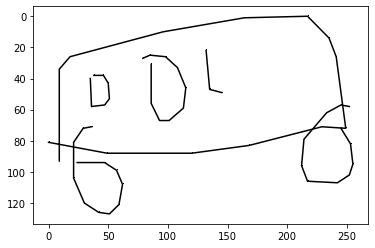

In [7]:

qd = QuickDrawData()
anvil = qd.get_drawing("bus")

print(anvil.image_data)

pil_im = anvil.image
pil_im.show()

plt.gca().invert_yaxis()

for stroke in anvil.strokes:
    xarr = []
    yarr = []
#    plt.plot(stroke, marker = 'o')
    for x, y in stroke:
        xarr.append(x)
        yarr.append(y)
        #plt.plot(x, y, marker = ',')
        #print("x={} y={}".format(x, y)) 
    plt.plot(xarr,yarr, marker = ',', color="black")
plt.show()

In [8]:
annotation_path = 'coco/annotations/instances_val2017.json'
image_dir = 'coco/val2017'

coco_dataset = CocoDataset(annotation_path, image_dir)

html = coco_dataset.display_image(1584, use_url=True, show_polys=False)
bbox = coco_dataset.return_bbox(1584)
print(bbox)
IPython.display.HTML(html)

Image:
  license: 3
  file_name: 000000001584.jpg
  coco_url: http://images.cocodataset.org/val2017/000000001584.jpg
  height: 612
  width: 612
  date_captured: 2013-11-16 21:28:33
  flickr_url: http://farm8.staticflickr.com/7407/9165185795_3ed7135b77_z.jpg
  id: 1584
  segmentations (14):
    365622:blue:{'supercategory': 'vehicle', 'id': 6, 'name': 'bus'}
    512395:purple:{'supercategory': 'person', 'id': 1, 'name': 'person'}
    538134:red:{'supercategory': 'person', 'id': 1, 'name': 'person'}
    540946:green:{'supercategory': 'person', 'id': 1, 'name': 'person'}
    541559:orange:{'supercategory': 'person', 'id': 1, 'name': 'person'}
    542102:salmon:{'supercategory': 'person', 'id': 1, 'name': 'person'}
    550932:pink:{'supercategory': 'person', 'id': 1, 'name': 'person'}
    1364533:gold:{'supercategory': 'vehicle', 'id': 6, 'name': 'bus'}
    1689589:orchid:{'supercategory': 'person', 'id': 1, 'name': 'person'}
    1719530:slateblue:{'supercategory': 'person', 'id': 1, 'name

In [9]:
pylab.rcParams['figure.figsize'] = (8.0, 10.0)

annFile='coco/annotations/instances_val2017.json'

# initialize COCO api for instance annotations
coco=COCO(annFile)

loading annotations into memory...
Done (t=0.77s)
creating index...
index created!


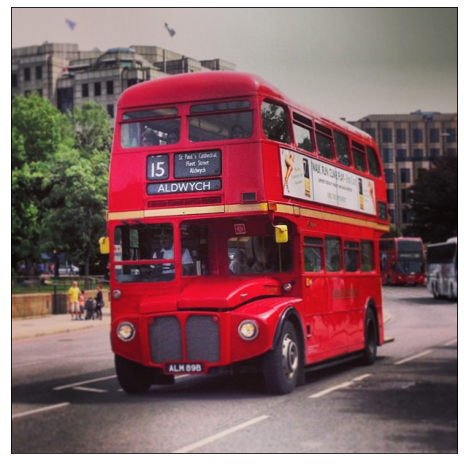

loading annotations into memory...
Done (t=0.69s)
creating index...
index created!


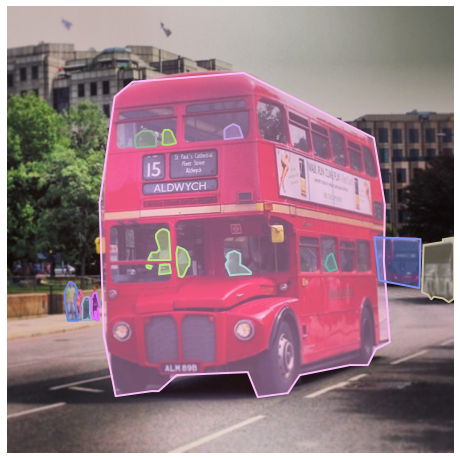

In [57]:
# get all images containing given categories, select one at random
catIds = coco.getCatIds(catNms=['bus']);
imgIds = coco.getImgIds(catIds=catIds );
imgIds = coco.getImgIds(imgIds = [1584])
img = coco.loadImgs(imgIds[np.random.randint(0,len(imgIds))])[0]

img = cv2.imread('coco/val2017/000000001584.jpg',1)
Cimg = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.imshow(Cimg, cmap = 'gray')
plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
plt.show()

dataDir='coco'
dataType='val2017'
annFile='{}/annotations/instances_{}.json'.format(dataDir,dataType)
coco=COCO(annFile)
ids = [10673, 1584]
ids = [1584]
# ids= [10673, 638724, 2162813]
annIds = coco.getAnnIds(imgIds=ids)
anns = coco.loadAnns(annIds)
plt.imshow(Cimg); plt.axis('off')
coco.showAnns(anns, draw_bbox=False)


[[255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 ...
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]]


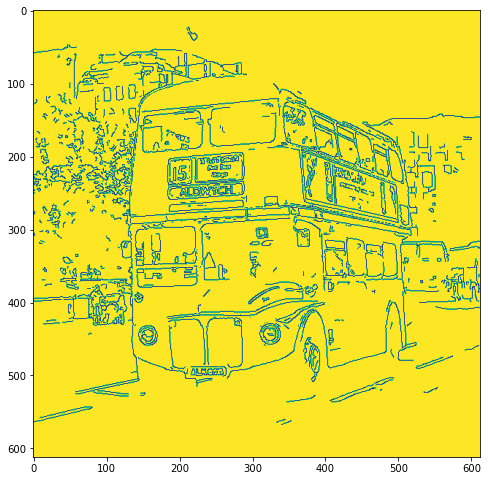

In [48]:
img = cv2.imread('coco/val2017/000000001584.jpg',1)
Cimg = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
grayImg = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

edges=cv2.Canny(img, 150, 200)
inv = cv2.bitwise_not(edges)
plt.imshow(inv)
print(inv)
plt.show()

In [69]:
def get_quickdraw_dims(drawing):
    smallest_x = float('inf')
    smallest_y = float('inf')
    largest_x = 0
    largest_y = 0

    for stroke in drawing.strokes:
        xarr = []
        yarr = []
    #    plt.plot(stroke, marker = 'o')

        for x, y in stroke:
            xarr.append(x)
            yarr.append(y)
            #plt.plot(x, y, marker = ',')
            #print("x={} y={}".format(x, y))
            if(x <= smallest_x):
                smallest_x = x
            if(y <= smallest_y):
                smallest_y = y
            if(x >= largest_x):
                largest_x = x
            if(y >= largest_y):
                largest_y = y

    #     plt.plot(xarr,yarr, marker = ',', color="white")

    width = largest_x-smallest_x
    height = largest_y - smallest_y

    return width, height

loading bus drawings
load complete
loading bus drawings
load complete
loading bus drawings
load complete
loading bus drawings
load complete
loading bus drawings
load complete
loading bus drawings
load complete
loading bus drawings
load complete
loading bus drawings
load complete
loading bus drawings
load complete
loading bus drawings
load complete
loading bus drawings
load complete
loading bus drawings
load complete
loading bus drawings
load complete
loading bus drawings
load complete
loading bus drawings
load complete


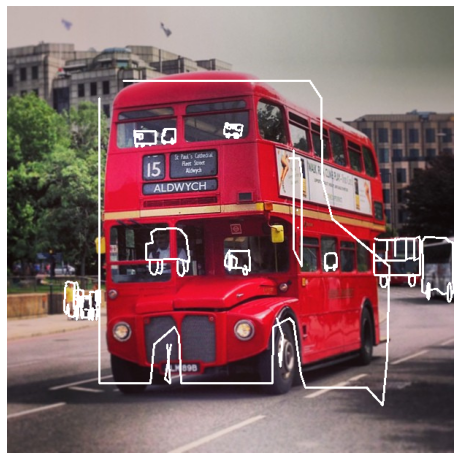

In [70]:
img = cv2.imread('coco/val2017/000000001584.jpg',1)
Cimg = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
grayImg = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

qd = QuickDrawData()
drawing = qd.get_drawing("bus")

#I = Cimg
plt.axis('off')

for ann in anns:

    [bbox_x, bbox_y, bbox_w, bbox_h] = ann['bbox']
    
    bbox_x = int(bbox_x)
    bbox_y = int(bbox_y)
    bbox_w = int(bbox_w)
    bbox_h = int(bbox_h)
    
    I = Cimg
    bbox_image = I[bbox_x:bbox_x+bbox_w, bbox_y:bbox_y+bbox_h]
    edges=cv2.Canny(bbox_image, 150, 200)
    inv = cv2.bitwise_not(edges)
    
    h, w = np.shape(inv)
    
    qdg = QuickDrawDataGroup("bus")
    smallest_norm = float('inf')

    qd = QuickDrawData()
    closest_drawing = 0

    for drawing in qdg.drawings:
        pix = np.array(drawing.image)
        pixgray = cv2.cvtColor(pix, cv2.COLOR_BGR2GRAY)
        
        #fnorm = np.linalg.norm(pixgray, 'fro')
        pixgray = cv2.resize(pixgray, (w, h))
        fnorm = np.linalg.norm(pixgray - inv, 'fro')
        
        if(fnorm < smallest_norm):
#             print(fnorm, 'fnorm')
#             print(smallest_norm)
            smallest_norm = fnorm
            closest_drawing = drawing.key_id

    final = qdg.search_drawings(key_id=closest_drawing)[0]

    width, height = get_quickdraw_dims(final)
    
    for stroke in final.strokes:
        xarr = []
        yarr = []
        for x, y in stroke:
            xarr.append(x)
            yarr.append(y)

        newx = [x * (bbox_w/width) + bbox_x for x in xarr]
        newy = [y * (bbox_h/height) + bbox_y for y in yarr]
        newx = np.rint(newx).astype(int)
        newy = np.rint(newy).astype(int)
        for i in range(0, len(newx) - 1):
            I = cv2.line(I, (newx[i],newy[i]), (newx[i+1],newy[i+1]), (255, 255, 255) , 2)
            
plt.imshow(I)
plt.show()

loading bus drawings
load complete
loading bus drawings
load complete
loading bus drawings
load complete
loading bus drawings
load complete
loading bus drawings
load complete
loading bus drawings
load complete
loading bus drawings
load complete
loading bus drawings
load complete
loading bus drawings
load complete
loading bus drawings
load complete
loading bus drawings
load complete
loading bus drawings
load complete
loading bus drawings
load complete
loading bus drawings
load complete
loading bus drawings
load complete


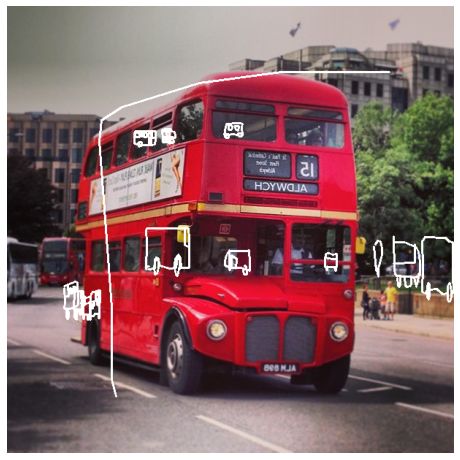

In [72]:
# flipped


img = cv2.imread('coco/val2017/000000001584.jpg',1)
img = cv2.flip(img, 1)
Cimg = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
grayImg = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

qd = QuickDrawData()
drawing = qd.get_drawing("bus")

#I = Cimg
plt.axis('off')

for ann in anns:

    [bbox_x, bbox_y, bbox_w, bbox_h] = ann['bbox']
    
    bbox_x = int(bbox_x)
    bbox_y = int(bbox_y)
    bbox_w = int(bbox_w)
    bbox_h = int(bbox_h)
    
    I = Cimg
    bbox_image = I[bbox_x:bbox_x+bbox_w, bbox_y:bbox_y+bbox_h]
    edges=cv2.Canny(bbox_image, 150, 200)
    inv = cv2.bitwise_not(edges)
    
    h, w = np.shape(inv)
    
    qdg = QuickDrawDataGroup("bus")
    smallest_norm = float('inf')

    qd = QuickDrawData()
    closest_drawing = 0

    for drawing in qdg.drawings:
        pix = np.array(drawing.image)
        pixgray = cv2.cvtColor(pix, cv2.COLOR_BGR2GRAY)
        
        #fnorm = np.linalg.norm(pixgray, 'fro')
        pixgray = cv2.resize(pixgray, (w, h))
        fnorm = np.linalg.norm(pixgray - inv, 'fro')
        
        if(fnorm < smallest_norm):
#             print(fnorm, 'fnorm')
#             print(smallest_norm)
            smallest_norm = fnorm
            closest_drawing = drawing.key_id

    final = qdg.search_drawings(key_id=closest_drawing)[0]

    width, height = get_quickdraw_dims(final)
    
    for stroke in final.strokes:
        xarr = []
        yarr = []
        for x, y in stroke:
            xarr.append(x)
            yarr.append(y)

        newx = [x * (bbox_w/width) + bbox_x for x in xarr]
        newy = [y * (bbox_h/height) + bbox_y for y in yarr]
        newx = np.rint(newx).astype(int)
        newy = np.rint(newy).astype(int)
        for i in range(0, len(newx) - 1):
            I = cv2.line(I, (newx[i],newy[i]), (newx[i+1],newy[i+1]), (255, 255, 255) , 2)
            
plt.imshow(I)
plt.show()